In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import mysql.connector as sql
import math

## Lets see the description of data

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
## Unique Transaction Types
data['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [7]:
## step size 
print('The step include',len(data['step'].unique()),'unique values')

The step include 743 unique values


In [8]:
#Total number of unique customers
print(f"Total number of unique customers are {data.nameOrig.nunique()}")
print(f"Total number of unique receipents are {data.nameDest.nunique()}")


Total number of unique customers are 6353307
Total number of unique receipents are 2722362


In [9]:
## Lets see if there was any fraud transaction between each combination of customer and merchants

print('Customer_Merchant_TRX','--', len(data[(data['nameOrig'].str.startswith('C')) & (data['nameDest'].str.startswith('M')) & (data['isFraud']==1)]))
print('Customer_Customer_TRX','--', len(data[(data['nameOrig'].str.startswith('C')) & (data['nameDest'].str.startswith('C')) & (data['isFraud']==1)]))
print('Merchant_Customer_TRX','--', len(data[(data['nameOrig'].str.startswith('M')) & (data['nameDest'].str.startswith('C')) & (data['isFraud']==1)]))
print('Merchant_Merchant_TRX','--', len(data[(data['nameOrig'].str.startswith('M')) & (data['nameDest'].str.startswith('M')) & (data['isFraud']==1)]))


Customer_Merchant_TRX -- 0
Customer_Customer_TRX -- 8213
Merchant_Customer_TRX -- 0
Merchant_Merchant_TRX -- 0


In [10]:
## 
df4 = (data[data['isFraud'] == 1].groupby('nameDest')['nameDest'].count()>1).to_frame().rename(columns = {'nameDest':'>1TRX'}).reset_index()
print('there are',len(df4[df4['>1TRX'] == True]),'transaction where there are multiple transaction at receipent side and atleast one fraud is detected')
print('--'*50)
df5 = (data[data['isFraud'] == 1].groupby('nameOrig')['nameOrig'].count()>1).to_frame().rename(columns = {'nameOrig':'>1TRX'}).reset_index()
print('there are',len(df5[df5['>1TRX'] == True]),'transaction where there are multiple transaction from origin side and atleast one fraud is detected')
print('--'*50)

there are 44 transaction where there are multiple transaction at receipent side and atleast one fraud is detected
----------------------------------------------------------------------------------------------------
there are 0 transaction where there are multiple transaction from origin side and atleast one fraud is detected
----------------------------------------------------------------------------------------------------


In [41]:
Cash_in_diff = len(data[(np.ceil(data['oldbalanceOrg'] +data['amount']) != np.ceil(data['newbalanceOrig'])) & (data['type'] == 'CASH_IN')])
print(f'number of cash in transaction where there is difference are {Cash_in_diff}')
print('--'*50)
Cash_out_diff = len(data[(np.ceil(data['oldbalanceDest'] + data['amount']) != np.ceil(data['newbalanceDest'])) & (data['type'] == 'CASH_OUT')])
print(f'number of cash out transaction where there is difference are {Cash_out_diff}')
print('--'*50)
debit_diff = len(data[(np.ceil(data['oldbalanceOrg'] - data['amount']) != np.ceil(data['newbalanceOrig'])) & (data['type'] == 'DEBIT')])
print(f'number of debit transaction where there is difference are {debit_diff}')
print('--'*50)
trans_diff = len(data[(np.ceil(data['oldbalanceOrg'] - data['amount']) != np.ceil(data['newbalanceOrig'])) & (data['type'] == 'TRANSFER')])
print(f'number of transfer transaction where there is difference are {trans_diff}')

number of cash in transaction where there is difference are 2211
----------------------------------------------------------------------------------------------------
number of cash out transaction where there is difference are 215886
----------------------------------------------------------------------------------------------------
number of debit transaction where there is difference are 11792
----------------------------------------------------------------------------------------------------
number of transfer transaction where there is difference are 507552


<AxesSubplot:xlabel='isFraud', ylabel='count'>

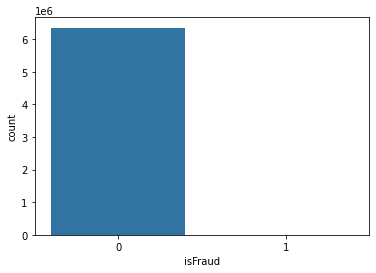

In [12]:
## Check if the output class is in balance 
sns.countplot(data['isFraud'])

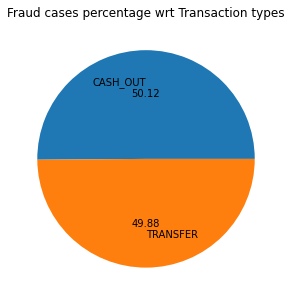

In [13]:
## let us check which payment type has highest fraud cases
plt.figure(figsize=(20,5))
labels = data[data['isFraud'] == 1].groupby(data['type'])['isFraud'].count().index
plt.title('Fraud cases percentage wrt Transaction types')
plt.pie(data[data['isFraud'] == 1].groupby(data['type'])['isFraud'].count(),labels=labels,autopct='%.2f'
        ,labeldistance=0.7)
plt.show()

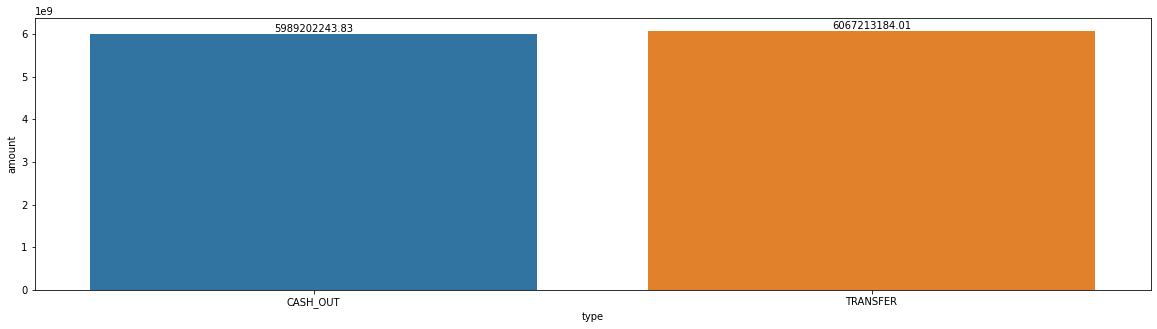

In [14]:
## let us see total amount value wrt to transaction type where fraud has happened
plt.figure(figsize = (20,5))
total_amt_wrt_fraud = data[data['isFraud'] == 1].groupby('type')['amount'].sum().reset_index()
chart = sns.barplot(x = total_amt_wrt_fraud['type'], y = total_amt_wrt_fraud['amount'],)
chart.bar_label(chart.containers[0],fmt='%.2f')
plt.show()


<Figure size 864x360 with 0 Axes>

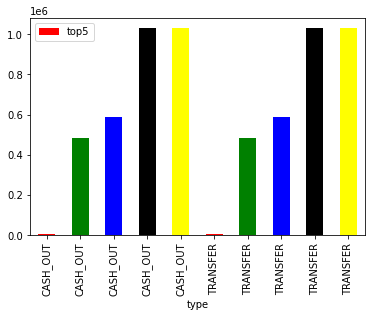

In [15]:
## let us see top 5 amount value wrt to transaction type where fraud has happened

plt.figure(figsize = (12,5))
top5_amt = data[data['isFraud'] == 1].groupby('type')['amount'].nlargest(5).reset_index().rename(columns = {'level_1':'top5'})
colors = ['red', 'green', 'blue', 'black','yellow']
top5_amt.plot(x='type', y= 'top5', kind = 'bar', 
                    stacked=True, 
                    color = colors)
plt.show()

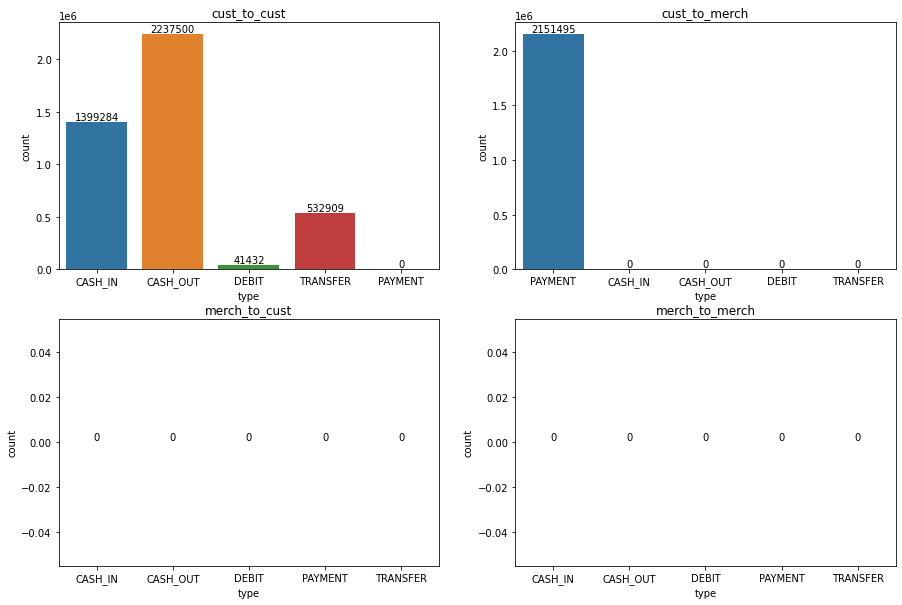

In [18]:
### let see the the number of transaction based on type to each customer(origin and dest)
c_c = data[(data['nameOrig'].str.startswith('C')) & (data['nameDest'].str.startswith('C'))].groupby('type')['type'].count().to_frame().rename(columns = {'type':'count'}).reset_index()
c_m = data[(data['nameOrig'].str.startswith('C')) & (data['nameDest'].str.startswith('M'))].groupby('type')['type'].count().to_frame().rename(columns = {'type':'count'}).reset_index()
m_c = data[(data['nameOrig'].str.startswith('M')) & (data['nameDest'].str.startswith('C'))].groupby('type')['type'].count().to_frame().rename(columns = {'type':'count'}).reset_index()
m_m = data[(data['nameOrig'].str.startswith('M')) & (data['nameDest'].str.startswith('M'))].groupby('type')['type'].count().to_frame().rename(columns = {'type':'count'}).reset_index()

trx_typ = ['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN']
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,10))
df_list = [c_c,c_m,m_c,m_m]
ax_lst = {(0,0):'cust_to_cust',
          (0,1):'cust_to_merch',
          (1,0):'merch_to_cust',
          (1,1):'merch_to_merch'}
j = 0
for df in df_list:
    ls = set(df['type'].unique())
    missing = list(sorted(set(trx_typ) - ls))
    for i in missing:
        df = df.append({'type':i,'count':0},ignore_index=True)
    chart = sns.barplot(x = df['type'],y =df['count'],ax=axes[list(ax_lst.keys())[j]])
    axes[list(ax_lst.keys())[j]].title.set_text(ax_lst[list(ax_lst.keys())[j]])
    chart.bar_label(chart.containers[0],fmt='%d')
    j+=1



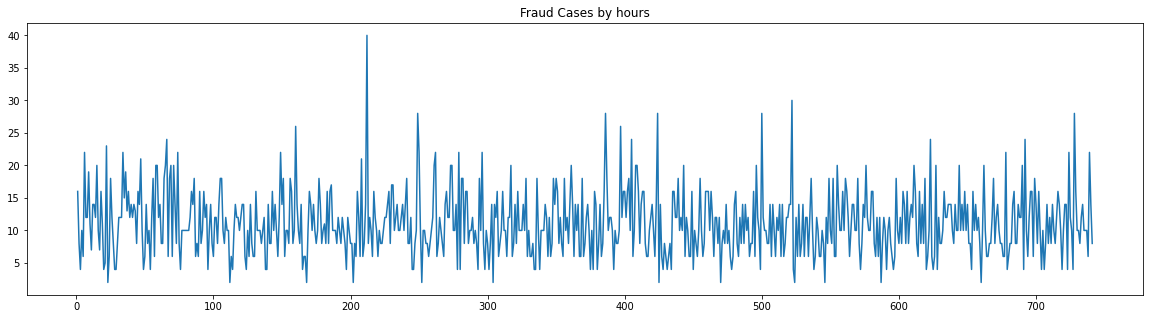

In [19]:
## lets check at which hour of the month most of the fraud happened

plt.figure(figsize = (20,5))
fraud_every_hour = data[data['isFraud'] == 1].groupby('step')['isFraud'].count()
sns.lineplot(x = list(range(1,742)), y = list(fraud_every_hour.values))
plt.title('Fraud Cases by hours')
plt.show()

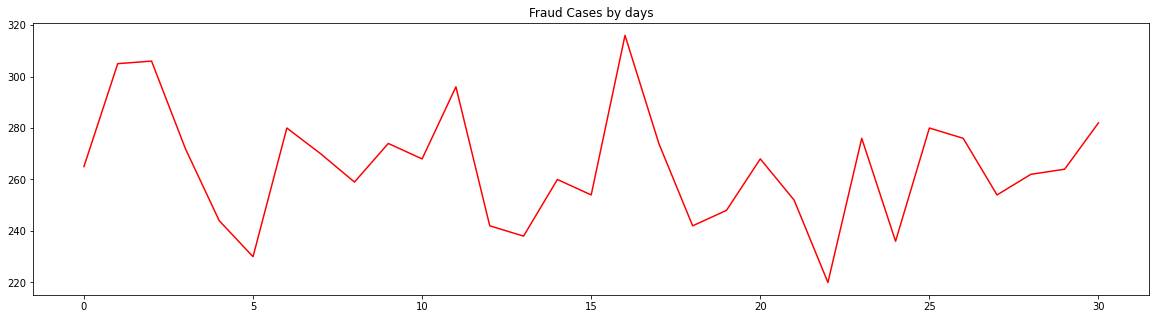

In [22]:
## lets check day wise fraud statistics

plt.figure(figsize = (20,5))
fraud_by_day = data[data['isFraud'] == 1].groupby('step')['isFraud'].count().reset_index()
fraud_by_day['day'] = [math.floor(float(x)/24) for x in fraud_by_day['step']]
fraud_by_day = fraud_by_day.groupby('day')['isFraud'].sum().reset_index()
sns.lineplot(x = list(range(0,31)), y = list(fraud_by_day['isFraud']),color='r')
plt.title('Fraud Cases by days')
plt.show()

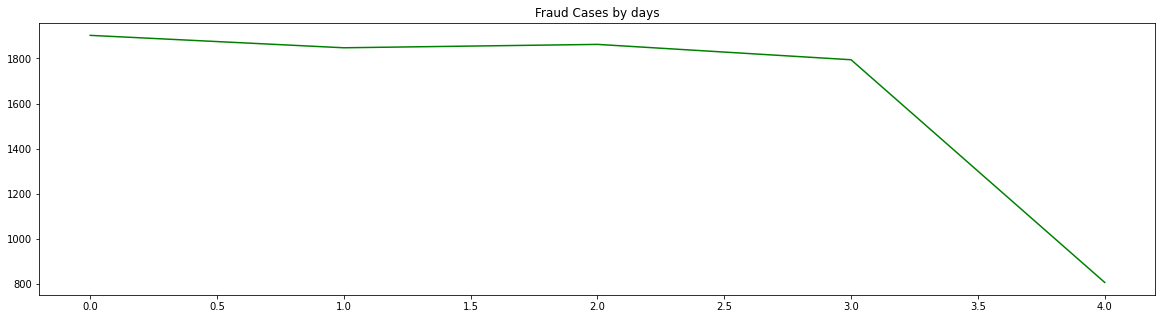

In [23]:
## lets check week wise fraud statistics

plt.figure(figsize = (20,5))
fraud_by_week = data[data['isFraud'] == 1].groupby('step')['isFraud'].count().reset_index()
fraud_by_week['week'] = [math.floor(float(x)/168) for x in fraud_by_week['step']]
fraud_by_week = fraud_by_week.groupby('week')['isFraud'].sum().reset_index()
sns.lineplot(x = list(range(0,5)), y = list(fraud_by_week['isFraud']),color='g')
plt.title('Fraud Cases by days')
plt.show()

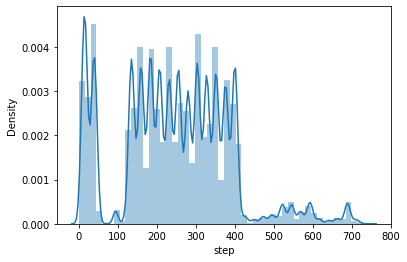

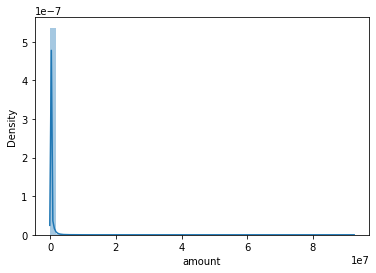

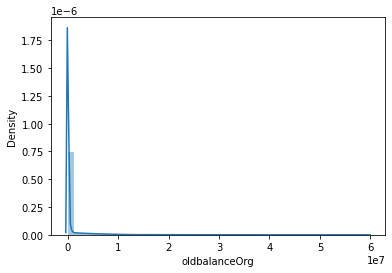

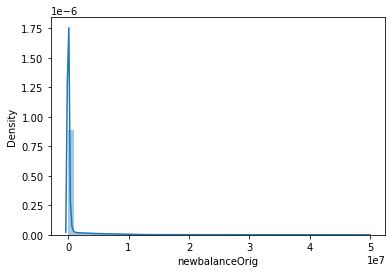

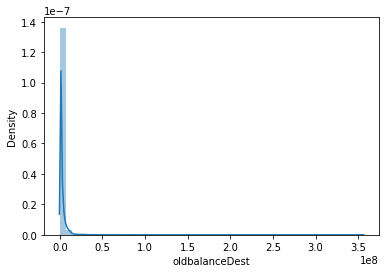

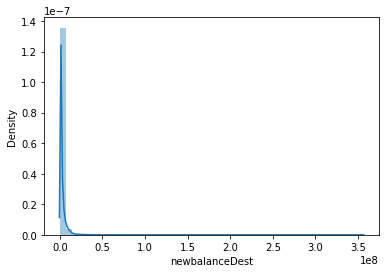

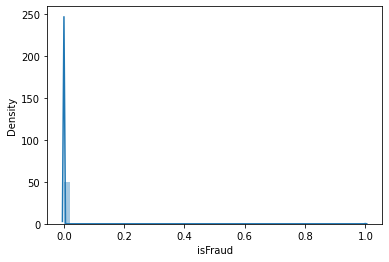

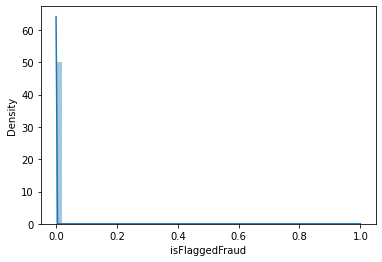

In [69]:
for i, col in enumerate(data.select_dtypes(exclude = ['object']).columns):
    plt.figure(i)
    sns.distplot(data[col])
    
    

<AxesSubplot:>

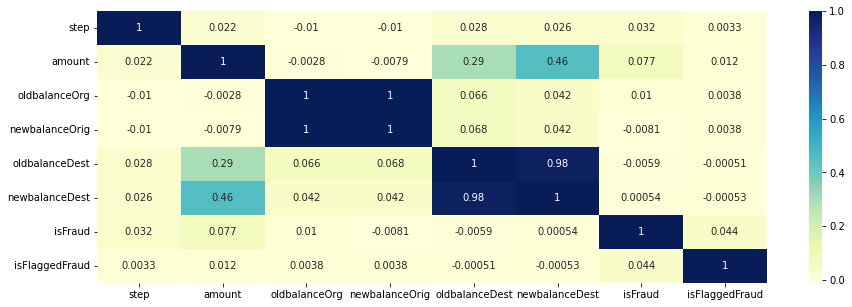

In [75]:
## let us check correlation between all numerice vars

plt.figure(figsize = (15,5))
sns.heatmap(data.corr(), cmap = 'YlGnBu',annot=True)